<a href="https://colab.research.google.com/github/bu11ymaguire/Machin-Learning1/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# 필요한 라이브러리 설치
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm

print("필요 라이브러리 설치 완료.")

Mounted at /content/drive
필요 라이브러리 설치 완료.


In [2]:
# 데이터 처리 및 분석
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지 (영어 출력에도 영향 없음)

# 머신러닝 모델
from sklearn.ensemble import RandomForestRegressor # RandomForest 추가
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb

# 경고 무시 (선택 사항)
import warnings
warnings.filterwarnings('ignore')

print("필요 라이브러리 임포트 및 시각화 설정 완료.")

필요 라이브러리 임포트 및 시각화 설정 완료.


In [3]:
# 데이터 로드
file_path = '/content/drive/MyDrive/koreaTrip.csv'
df = pd.read_csv(file_path)

print("데이터프레임 첫 5행:")
print(df.head())
print("\n데이터프레임 정보:")
df.info()
print("\n결측치 확인:")
print(df.isnull().sum())

데이터프레임 첫 5행:
  시간(연도.월)       관광객수 1인당 평균 지출(USD$) 관광수입(1K USD$)    입국자 수  서울 평균 기온  \
0   Jan-15    723,255           1,014     1,230,500  917,054       3.6   
1   Feb-15    815,138            1066       1221300  1050706       6.0   
2   Mar-15    958,493            1202       1561500  1238144      12.4   
3   Apr-15  1,112,904            1241       1499600  1384567      18.8   
4   May-15  1,060,730            1088       1485500  1334212      24.9   

   부산 평균 기온  제주 평균 기온  서울(경기) 평균 강수일수  부산(경남) 평균 강수일수  ...  "여행 한국"(구글트랜드_태국)  \
0       9.4      10.2             7.0             8.9  ...                 81   
1      10.2      10.1             5.7             5.5  ...                 61   
2      14.3      13.6             3.7             5.8  ...                 68   
3      17.8      19.2            11.5            15.3  ...                 66   
4      22.9      22.7             5.8             7.9  ...                 62   

   "서울 한국"(구글트랜드_태국)  "한국 가기"(구글트랜드_태국)  환율(USD-KRW)  교

In [4]:
# 1. '시간(연도.월)' 컬럼 Datetime으로 변환 및 인덱스 설정
df['시간(연도.월)'] = pd.to_datetime(df['시간(연도.월)'], format='%b-%y')
df.set_index('시간(연도.월)', inplace=True)

# 2. 모든 숫자 컬럼의 콤마 제거 및 float 타입 변환
df.columns = df.columns.str.replace('"', '').str.strip()

# 컬럼명 번역 매핑 (영어 시각화 및 코드 가독성을 위해)
# 실제 데이터의 컬럼명과 일치하는지 확인 후 수정해주세요.
column_translation = {
    '관광수입(1K USD$)': 'Tourism_Revenue_1K_USD',
    '관광객수': 'Num_Tourists',
    '1인당 평균 지출(USD$)': 'Avg_Spend_Per_Tourist_USD',
    '입국자 수': 'Num_Arrivals',
    '항공편(인천국제공항_도착여객기)': 'Incheon_Flights_Arrival',
    '환율(USD-KRW)': 'Exchange_Rate_USD_KRW',
    '교통 인프라(지하철_연간)': 'Transportation_Subway_Annual',
    '면세점_외국인 결제 데이터(단위수: 1M USD$)': 'DutyFree_Foreigner_Payment_1M_USD',
    '면세점_외국인_인원수(단위 수 천명)': 'DutyFree_Foreigner_Count_1K',
    '서부텍사스산_원유(WTI) (단위 수: 1 USD$)': 'WTI_Crude_Oil_USD',
    '한국- 전국소비자 물가지수': 'Korea_CPI',
    '팬데믹': 'Pandemic',
    '한국(구글트랜드_미국)': 'Korea_GoogleTrend_US',
    '서울(구글트랜드_미국)': 'Seoul_GoogleTrend_US',
    'KOREA(구글트랜드_미국)': 'KOREA_GoogleTrend_US',
    'seoul(구글트랜드_미국)': 'seoul_GoogleTrend_US',
    'k-pop(구글트랜드_미국)': 'kpop_GoogleTrend_US',
    '한국 여행(구글트랜드_미국)': 'Korea_Travel_GoogleTrend_US',
    '서울 여행(구글트랜드_미국)': 'Seoul_Travel_GoogleTrend_US',
    '한국 여행(구글트랜드_일본)': 'Korea_Travel_GoogleTrend_JP',
    '서울 관광(구글트랜드_일본)': 'Seoul_Tourism_GoogleTrend_JP',
    '부산 여행(구글트랜드_일본)': 'Busan_Travel_GoogleTrend_JP',
    '여행 한국(구글트랜드_태국)': 'Travel_Korea_GoogleTrend_TH',
    '서울 한국(구글트랜드_태국)': 'Seoul_Korea_GoogleTrend_TH',
    '한국 가기(구글트랜드_태국)': 'Go_Korea_GoogleTrend_TH'
}

df.rename(columns=column_translation, inplace=True)

# 숫자형으로 변환할 컬럼 리스트 (번역된 컬럼명 사용)
numerical_cols = [
    'Tourism_Revenue_1K_USD', 'Num_Tourists', 'Avg_Spend_Per_Tourist_USD', 'Num_Arrivals',
    'Incheon_Flights_Arrival', 'Exchange_Rate_USD_KRW', 'Transportation_Subway_Annual',
    'DutyFree_Foreigner_Payment_1M_USD', 'DutyFree_Foreigner_Count_1K',
    'WTI_Crude_Oil_USD', 'Korea_CPI', 'Korea_GoogleTrend_US',
    'Seoul_GoogleTrend_US', 'KOREA_GoogleTrend_US', 'seoul_GoogleTrend_US',
    'kpop_GoogleTrend_US', 'Korea_Travel_GoogleTrend_US', 'Seoul_Travel_GoogleTrend_US',
    'Korea_Travel_GoogleTrend_JP', 'Seoul_Tourism_GoogleTrend_JP', 'Busan_Travel_GoogleTrend_JP',
    'Travel_Korea_GoogleTrend_TH', 'Seoul_Korea_GoogleTrend_TH', 'Go_Korea_GoogleTrend_TH'
]

for col in numerical_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')
    else:
        print(f"Warning: Column '{col}' does not exist in the DataFrame. Please check column names.")

# 3. 결측치 처리 (선형 보간법)
print("\nMissing values before interpolation:")
print(df.isnull().sum().to_string()) # to_string()을 사용하여 모든 행 출력
df.interpolate(method='linear', inplace=True)
print("\nMissing values after interpolation:")
print(df.isnull().sum().to_string())

# 4. Pandemic 컬럼 정수형 변환
if 'Pandemic' in df.columns:
    df['Pandemic'] = df['Pandemic'].astype(int)

print("\nDataFrame info after preprocessing:")
df.info()
print("\nFirst 5 rows of DataFrame after preprocessing:")
print(df.head())


Missing values before interpolation:
Num_Tourists                         0
Avg_Spend_Per_Tourist_USD            0
Tourism_Revenue_1K_USD               0
Num_Arrivals                         0
서울 평균 기온                             0
부산 평균 기온                             0
제주 평균 기온                             0
서울(경기) 평균 강수일수                       0
부산(경남) 평균 강수일수                       0
제주 평균 강수일수                           0
공휴일                                  0
Incheon_Flights_Arrival              0
Korea_GoogleTrend_US                 0
Seoul_GoogleTrend_US                 0
Seoul_Travel_GoogleTrend_US          0
Korea_Travel_GoogleTrend_US          0
kpop_GoogleTrend_US                  0
Korea_Travel_GoogleTrend_JP          0
Seoul_Tourism_GoogleTrend_JP         0
Busan_Travel_GoogleTrend_JP          0
Travel_Korea_GoogleTrend_TH          0
Seoul_Korea_GoogleTrend_TH           0
Go_Korea_GoogleTrend_TH              0
Exchange_Rate_USD_KRW                0
Transportation_Subway_Annu

In [5]:
print("--- Feature Engineering Started ---")

# 1. 시간 기반 특성 생성
df['year'] = df.index.year
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['day_of_week'] = df.index.dayofweek
df['day_of_year'] = df.index.dayofyear
df['week_of_year'] = df.index.isocalendar().week.astype(int)

# 2. 지연 특성 (Lagged Features)
target_col = 'Tourism_Revenue_1K_USD' # 목표 변수 번역명
df[f'{target_col}_lag1'] = df[target_col].shift(1)
df[f'{target_col}_lag3'] = df[target_col].shift(3)
df[f'{target_col}_lag6'] = df[target_col].shift(6)
df[f'{target_col}_lag12'] = df[target_col].shift(12)

df['Num_Tourists_lag1'] = df['Num_Tourists'].shift(1)
df['Exchange_Rate_USD_KRW_lag1'] = df['Exchange_Rate_USD_KRW'].shift(1)

# 3. 이동 평균 특성 (Moving Average Features)
df[f'{target_col}_rolling_mean3'] = df[target_col].rolling(window=3).mean()
df[f'{target_col}_rolling_mean6'] = df[target_col].rolling(window=6).mean()

# 4. 새로 생성된 NaN 값 처리 (초기 행 제거)
initial_nan_count = df.isnull().sum().sum()
if initial_nan_count > 0:
    print(f"\nNumber of initial NaN values due to new feature creation: {initial_nan_count}")
    df.dropna(inplace=True)
    print("Rows with NaN values dropped.")
else:
    print("\nNo NaN values after new feature creation.")

print("\n--- Feature Engineering Completed ---")
print("DataFrame info after feature engineering:")
df.info()
print("\nFirst 5 rows of DataFrame after feature engineering:")
print(df.head())
print("\nLast 5 rows of DataFrame after feature engineering:")
print(df.tail())

--- Feature Engineering Started ---

Number of initial NaN values due to new feature creation: 31
Rows with NaN values dropped.

--- Feature Engineering Completed ---
DataFrame info after feature engineering:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 2016-01-01 to 2024-12-01
Data columns (total 44 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Num_Tourists                          108 non-null    int64  
 1   Avg_Spend_Per_Tourist_USD             108 non-null    int64  
 2   Tourism_Revenue_1K_USD                108 non-null    int64  
 3   Num_Arrivals                          108 non-null    int64  
 4   서울 평균 기온                              108 non-null    float64
 5   부산 평균 기온                              108 non-null    float64
 6   제주 평균 기온                              108 non-null    float64
 7   서울(경기) 평균 강수일수                        108 non-null    float

In [6]:
print("--- Data Splitting Started ---")

# 목표 변수 설정
target_col = 'Tourism_Revenue_1K_USD'
features = [col for col in df.columns if col != target_col]

X = df[features]
y = df[target_col]

# 데이터 분할 전략 (마지막 12개월 테스트, 그 이전 12개월 검증)
test_size = 12
val_size = 12

train_end_index = len(df) - test_size - val_size
val_end_index = len(df) - test_size

X_train = X.iloc[:train_end_index]
y_train = y.iloc[:train_end_index]

X_val = X.iloc[train_end_index:val_end_index]
y_val = y.iloc[train_end_index:val_end_index]

X_test = X.iloc[val_end_index:]
y_test = y.iloc[val_end_index:]

print(f"Total data period: {df.index.min().strftime('%Y-%m')} ~ {df.index.max().strftime('%Y-%m')}")
print(f"Train set period: {X_train.index.min().strftime('%Y-%m')} ~ {X_train.index.max().strftime('%Y-%m')} (Duration: {len(X_train)} months)")
print(f"Validation set period: {X_val.index.min().strftime('%Y-%m')} ~ {X_val.index.max().strftime('%Y-%m')} (Duration: {len(X_val)} months)")
print(f"Test set period: {X_test.index.min().strftime('%Y-%m')} ~ {X_test.index.max().strftime('%Y-%m')} (Duration: {len(X_test)} months)")

print(f"\nX_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

print("\n--- Data Splitting Completed ---")

--- Data Splitting Started ---
Total data period: 2016-01 ~ 2024-12
Train set period: 2016-01 ~ 2022-12 (Duration: 84 months)
Validation set period: 2023-01 ~ 2023-12 (Duration: 12 months)
Test set period: 2024-01 ~ 2024-12 (Duration: 12 months)

X_train shape: (84, 43), y_train shape: (84,)
X_val shape: (12, 43), y_val shape: (12,)
X_test shape: (12, 43), y_test shape: (12,)

--- Data Splitting Completed ---


--- Random Forest Model Training and Evaluation Started (Pandemic Included) ---

Random Forest Validation MAE: 144162.12
Random Forest Validation RMSE: 162266.15
Random Forest Validation R2: 0.33
Random Forest Test MAE: 101223.03
Random Forest Test RMSE: 137436.51
Random Forest Test R2: 0.55


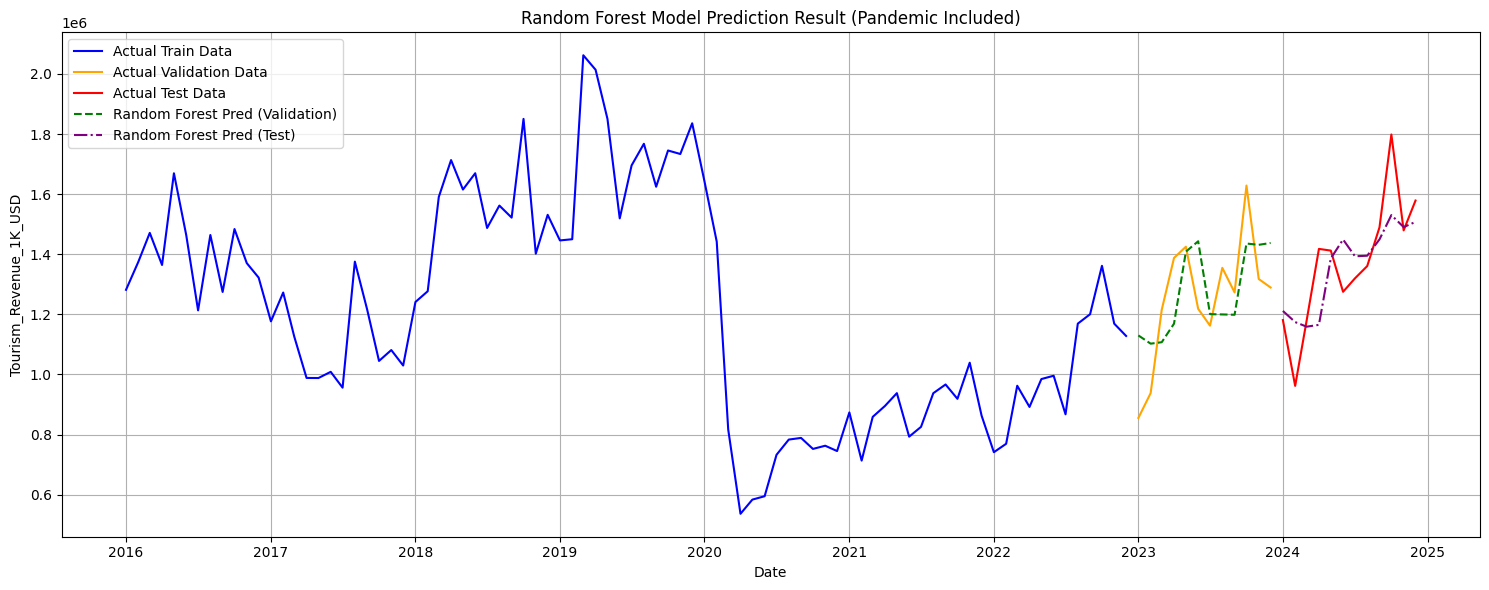

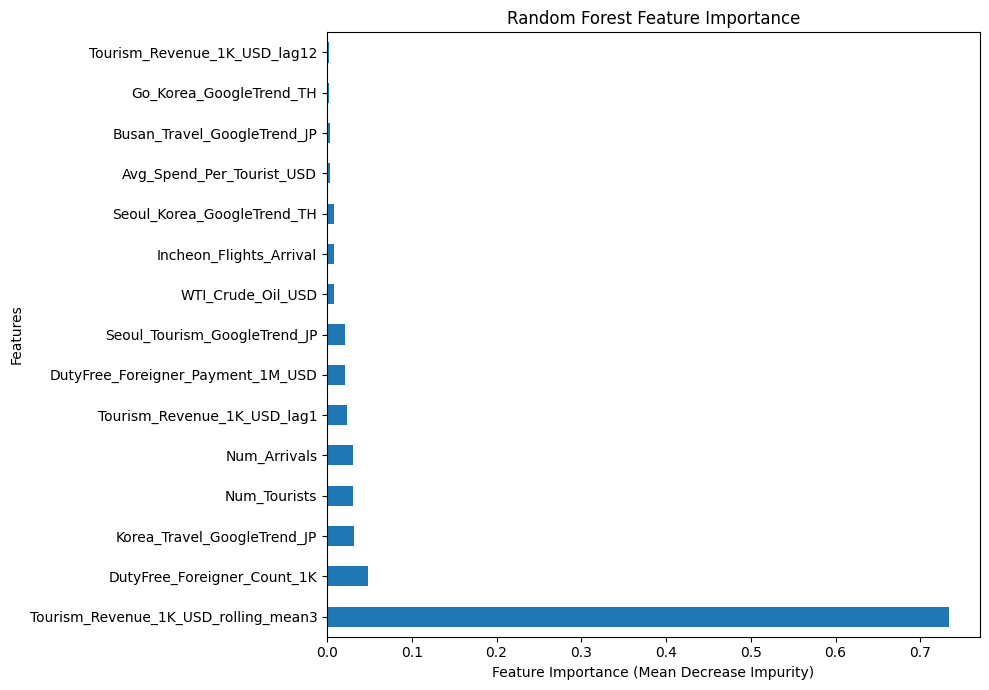

--- Random Forest Model Training and Evaluation Completed ---


In [7]:
print("--- Random Forest Model Training and Evaluation Started (Pandemic Included) ---")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# 검증 세트 예측
rf_val_preds = rf_model.predict(X_val)
mae_rf_val = mean_absolute_error(y_val, rf_val_preds)
rmse_rf_val = np.sqrt(mean_squared_error(y_val, rf_val_preds))
r2_rf_val = r2_score(y_val, rf_val_preds)
print(f"\nRandom Forest Validation MAE: {mae_rf_val:.2f}")
print(f"Random Forest Validation RMSE: {rmse_rf_val:.2f}")
print(f"Random Forest Validation R2: {r2_rf_val:.2f}")

# 테스트 세트 예측
rf_test_preds = rf_model.predict(X_test)
mae_rf_test = mean_absolute_error(y_test, rf_test_preds)
rmse_rf_test = np.sqrt(mean_squared_error(y_test, rf_test_preds))
r2_rf_test = r2_score(y_test, rf_test_preds)
print(f"Random Forest Test MAE: {mae_rf_test:.2f}")
print(f"Random Forest Test RMSE: {rmse_rf_test:.2f}")
print(f"Random Forest Test R2: {r2_rf_test:.2f}")

# 예측 결과 시각화
plt.figure(figsize=(15, 6))
plt.plot(y_train.index, y_train, label='Actual Train Data', color='blue')
plt.plot(y_val.index, y_val, label='Actual Validation Data', color='orange')
plt.plot(y_test.index, y_test, label='Actual Test Data', color='red')
plt.plot(X_val.index, rf_val_preds, label='Random Forest Pred (Validation)', color='green', linestyle='--')
plt.plot(X_test.index, rf_test_preds, label='Random Forest Pred (Test)', color='purple', linestyle='-.')
plt.title('Random Forest Model Prediction Result (Pandemic Included)')
plt.xlabel('Date')
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 특성 중요도 시각화
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importances.nlargest(15).plot(kind='barh', figsize=(10, 7))
plt.title('Random Forest Feature Importance')
plt.xlabel('Feature Importance (Mean Decrease Impurity)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

print("--- Random Forest Model Training and Evaluation Completed ---")

--- XGBoost Model Training and Evaluation Started (Pandemic Included) ---

XGBoost Validation MAE: 105066.04
XGBoost Validation RMSE: 134864.77
XGBoost Validation R2: 0.54
XGBoost Test MAE: 102866.50
XGBoost Test RMSE: 138744.69
XGBoost Test R2: 0.54


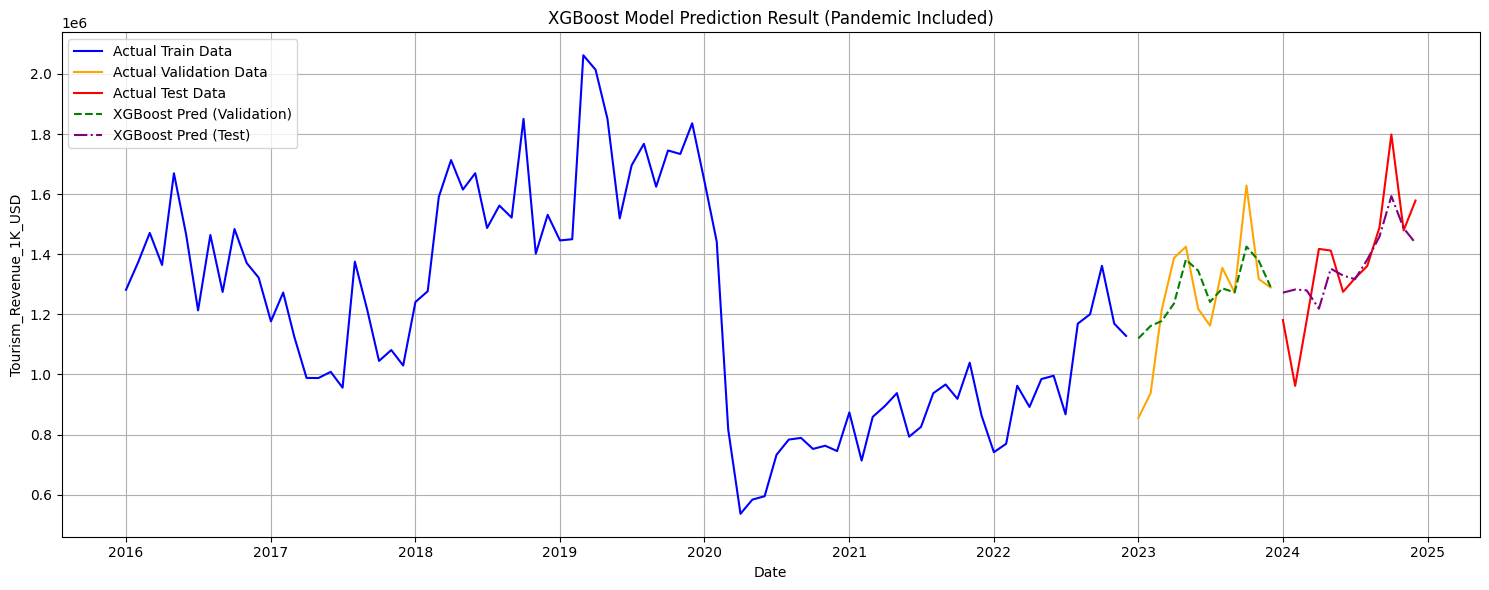

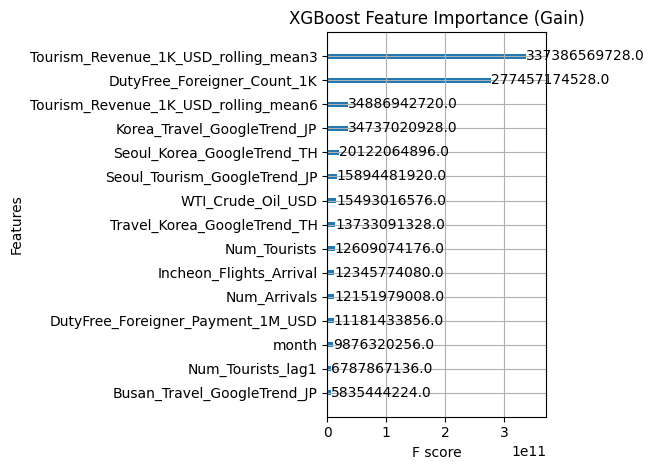

--- XGBoost Model Training and Evaluation Completed ---


In [8]:
print("--- XGBoost Model Training and Evaluation Started (Pandemic Included) ---")

import re
def clean_col_names(df_input):
    df_temp = df_input.copy()
    cols = df_temp.columns
    new_cols = []
    for col in cols:
        new_col = col.replace(' ', '_')
        new_col = re.sub(r'[^\w_]', '', new_col)
        new_cols.append(new_col)
    df_temp.columns = new_cols
    return df_temp

X_train_xgb = clean_col_names(X_train)
X_val_xgb = clean_col_names(X_val)
X_test_xgb = clean_col_names(X_test)

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,
    eval_metric='rmse'
)

xgb_model.fit(X_train_xgb, y_train,
              eval_set=[(X_val_xgb, y_val)],
              verbose=False)

# 검증 세트 예측
xgb_val_preds = xgb_model.predict(X_val_xgb)
mae_xgb_val = mean_absolute_error(y_val, xgb_val_preds)
rmse_xgb_val = np.sqrt(mean_squared_error(y_val, xgb_val_preds))
r2_xgb_val = r2_score(y_val, xgb_val_preds)
print(f"\nXGBoost Validation MAE: {mae_xgb_val:.2f}")
print(f"XGBoost Validation RMSE: {rmse_xgb_val:.2f}")
print(f"XGBoost Validation R2: {r2_xgb_val:.2f}")

# 테스트 세트 예측
xgb_test_preds = xgb_model.predict(X_test_xgb)
mae_xgb_test = mean_absolute_error(y_test, xgb_test_preds)
rmse_xgb_test = np.sqrt(mean_squared_error(y_test, xgb_test_preds))
r2_xgb_test = r2_score(y_test, xgb_test_preds)
print(f"XGBoost Test MAE: {mae_xgb_test:.2f}")
print(f"XGBoost Test RMSE: {rmse_xgb_test:.2f}")
print(f"XGBoost Test R2: {r2_xgb_test:.2f}")

# 예측 결과 시각화
plt.figure(figsize=(15, 6))
plt.plot(y_train.index, y_train, label='Actual Train Data', color='blue')
plt.plot(y_val.index, y_val, label='Actual Validation Data', color='orange')
plt.plot(y_test.index, y_test, label='Actual Test Data', color='red')
plt.plot(X_val.index, xgb_val_preds, label='XGBoost Pred (Validation)', color='green', linestyle='--')
plt.plot(X_test.index, xgb_test_preds, label='XGBoost Pred (Test)', color='purple', linestyle='-.')
plt.title('XGBoost Model Prediction Result (Pandemic Included)')
plt.xlabel('Date')
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 특성 중요도 시각화
xgb.plot_importance(xgb_model, importance_type='gain', max_num_features=15, title='XGBoost Feature Importance (Gain)')
plt.tight_layout()
plt.show()

print("--- XGBoost Model Training and Evaluation Completed ---")

--- LightGBM Model Training and Evaluation Started (Pandemic Included) ---
Cleaned X_train columns for LightGBM:
['Num_Tourists', 'Avg_Spend_Per_Tourist_USD', 'Num_Arrivals', '서울_평균_기온', '부산_평균_기온', '제주_평균_기온', '서울경기_평균_강수일수', '부산경남_평균_강수일수', '제주_평균_강수일수', '공휴일', 'Incheon_Flights_Arrival', 'Korea_GoogleTrend_US', 'Seoul_GoogleTrend_US', 'Seoul_Travel_GoogleTrend_US', 'Korea_Travel_GoogleTrend_US', 'kpop_GoogleTrend_US', 'Korea_Travel_GoogleTrend_JP', 'Seoul_Tourism_GoogleTrend_JP', 'Busan_Travel_GoogleTrend_JP', 'Travel_Korea_GoogleTrend_TH', 'Seoul_Korea_GoogleTrend_TH', 'Go_Korea_GoogleTrend_TH', 'Exchange_Rate_USD_KRW', 'Transportation_Subway_Annual', 'DutyFree_Foreigner_Payment_1M_USD', 'DutyFree_Foreigner_Count_1K', 'WTI_Crude_Oil_USD', 'Pandemic', 'Korea_CPI', 'year', 'month', 'quarter', 'day_of_week', 'day_of_year', 'week_of_year', 'Tourism_Revenue_1K_USD_lag1', 'Tourism_Revenue_1K_USD_lag3', 'Tourism_Revenue_1K_USD_lag6', 'Tourism_Revenue_1K_USD_lag12', 'Num_Tourists_lag1', 'Ex

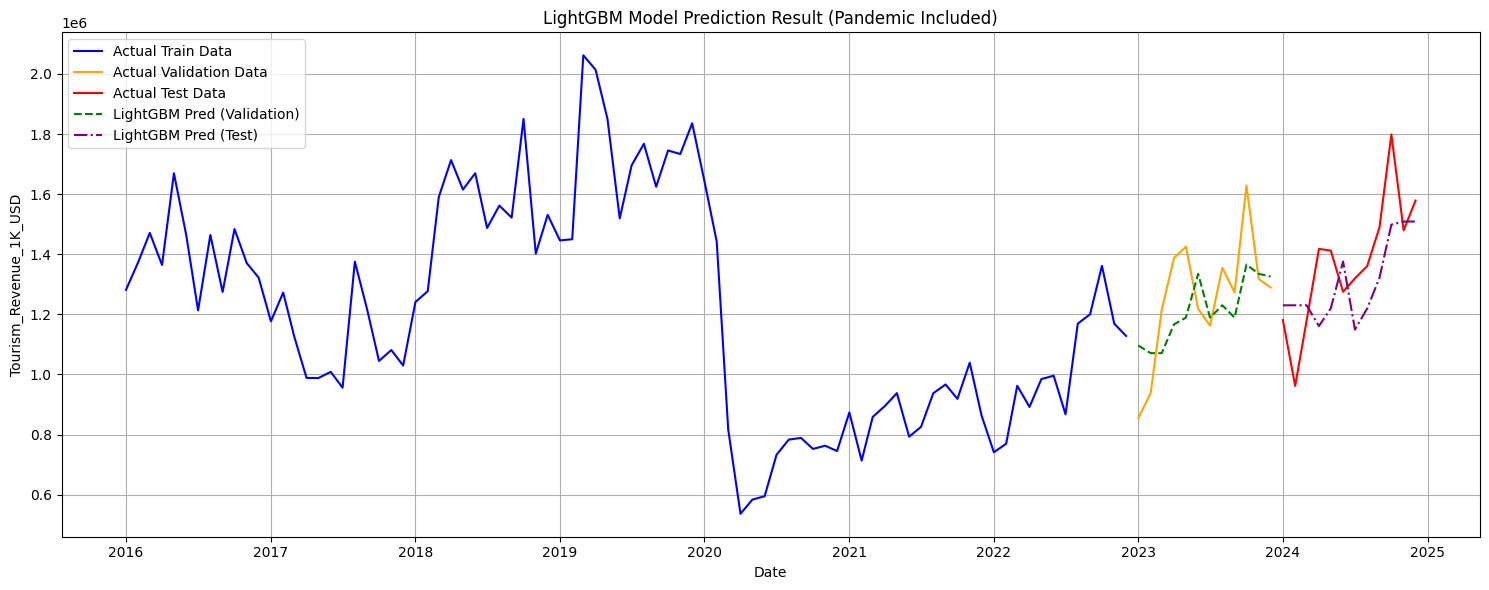

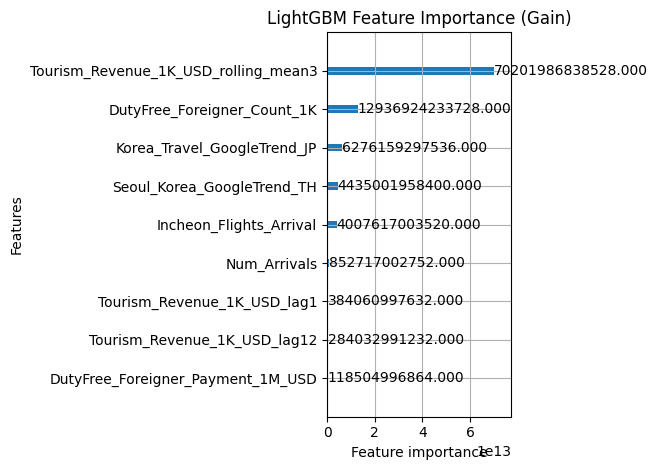

--- LightGBM Model Training and Evaluation Completed ---


In [9]:
print("--- LightGBM Model Training and Evaluation Started (Pandemic Included) ---")

import re
def clean_col_names(df_input):
    df_temp = df_input.copy()
    cols = df_temp.columns
    new_cols = []
    for col in cols:
        new_col = col.replace(' ', '_')
        new_col = re.sub(r'[^\w_]', '', new_col)
        new_cols.append(new_col)
    df_temp.columns = new_cols
    return df_temp

X_train_lgb = clean_col_names(X_train)
X_val_lgb = clean_col_names(X_val)
X_test_lgb = clean_col_names(X_test)

print("Cleaned X_train columns for LightGBM:")
print(X_train_lgb.columns.tolist())
print("-" * 50)

lgb_model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1
)

lgb_model.fit(X_train_lgb, y_train,
              eval_set=[(X_val_lgb, y_val)],
              eval_metric='mae',
              callbacks=[lgb.early_stopping(50, verbose=False)])

# 검증 세트 예측
lgb_val_preds = lgb_model.predict(X_val_lgb)
mae_lgb_val = mean_absolute_error(y_val, lgb_val_preds)
rmse_lgb_val = np.sqrt(mean_squared_error(y_val, lgb_val_preds))
r2_lgb_val = r2_score(y_val, lgb_val_preds)
print(f"\nLightGBM Validation MAE: {mae_lgb_val:.2f}")
print(f"LightGBM Validation RMSE: {rmse_lgb_val:.2f}")
print(f"LightGBM Validation R2: {r2_lgb_val:.2f}")

# 테스트 세트 예측
lgb_test_preds = lgb_model.predict(X_test_lgb)
mae_lgb_test = mean_absolute_error(y_test, lgb_test_preds)
rmse_lgb_test = np.sqrt(mean_squared_error(y_test, lgb_test_preds))
r2_lgb_test = r2_score(y_test, lgb_test_preds)
print(f"LightGBM Test MAE: {mae_lgb_test:.2f}")
print(f"LightGBM Test RMSE: {rmse_lgb_test:.2f}")
print(f"LightGBM Test R2: {r2_lgb_test:.2f}")

# 예측 결과 시각화
plt.figure(figsize=(15, 6))
plt.plot(y_train.index, y_train, label='Actual Train Data', color='blue')
plt.plot(y_val.index, y_val, label='Actual Validation Data', color='orange')
plt.plot(y_test.index, y_test, label='Actual Test Data', color='red')
plt.plot(X_val.index, lgb_val_preds, label='LightGBM Pred (Validation)', color='green', linestyle='--')
plt.plot(X_test.index, lgb_test_preds, label='LightGBM Pred (Test)', color='purple', linestyle='-.')
plt.title('LightGBM Model Prediction Result (Pandemic Included)')
plt.xlabel('Date')
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 특성 중요도 시각화
lgb.plot_importance(lgb_model, importance_type='gain', max_num_features=15, title='LightGBM Feature Importance (Gain)')
plt.tight_layout()
plt.show()

print("--- LightGBM Model Training and Evaluation Completed ---")

In [10]:
print("--- Data Splitting Started (Excluding Pandemic Period, 2023 for Validation, 2024 for Test) ---")

# 목표 변수 설정
target_col = 'Tourism_Revenue_1K_USD'
features = [col for col in df.columns if col != target_col]

# 'Pandemic' 컬럼이 0인 행만 선택 (팬데믹 기간 제외)
df_non_pandemic = df[df['Pandemic'] == 0].copy()

# 필터링된 데이터에서 X와 y 설정
X = df_non_pandemic[features]
y = df_non_pandemic[target_col]

# 연도를 기준으로 데이터 분할
# 2023년 데이터를 검증 세트로, 2024년 데이터를 테스트 세트로 사용합니다.
# 2024년 1월 현재 데이터가 존재하는지 확인해야 합니다.
# 데이터가 2024년 1월까지 포함되어 있다고 가정합니다.

# 학습 데이터: 2022년 12월까지의 팬데믹 이전 데이터
X_train = X[X.index.year <= 2022]
y_train = y[y.index.year <= 2022]

# 검증 데이터: 2023년 데이터
X_val = X[X.index.year == 2023]
y_val = y[y.index.year == 2023]

# 테스트 데이터: 2024년 데이터 (만약 2024년 데이터가 있다면)
X_test = X[X.index.year == 2024]
y_test = y[y.index.year == 2024]

# 만약 2024년 데이터가 없다면 경고 메시지를 출력합니다.
if X_test.empty:
    print("\n[WARNING] No data found for 2024 to use as test set.")
    print("Please check your 'koreaTrip.csv' file if it contains 2024 data.")
    print("Proceeding with 2023 as the latest available data for evaluation if no 2024 data.")
    # 이 경우, X_val, y_val을 최종 테스트 세트로 간주하거나, 별도의 논의가 필요합니다.
    # 여기서는 코드를 그대로 진행하되, 경고 메시지를 명확히 표시합니다.

print(f"Total non-pandemic data period: {df_non_pandemic.index.min().strftime('%Y-%m')} ~ {df_non_pandemic.index.max().strftime('%Y-%m')}")
print(f"Train set period (non-pandemic): {X_train.index.min().strftime('%Y-%m')} ~ {X_train.index.max().strftime('%Y-%m')} (Duration: {len(X_train)} months)")
print(f"Validation set period (non-pandemic): {X_val.index.min().strftime('%Y-%m')} ~ {X_val.index.max().strftime('%Y-%m')} (Duration: {len(X_val)} months)")
print(f"Test set period (non-pandemic): {X_test.index.min().strftime('%Y-%m')} ~ {X_test.index.max().strftime('%Y-%m')} (Duration: {len(X_test)} months)")

print(f"\nX_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

print("\n--- Data Splitting Completed (Pandemic Period Excluded, 2023 Validation, 2024 Test) ---")

--- Data Splitting Started (Excluding Pandemic Period, 2023 for Validation, 2024 for Test) ---
Total non-pandemic data period: 2016-01 ~ 2024-12
Train set period (non-pandemic): 2016-01 ~ 2022-12 (Duration: 62 months)
Validation set period (non-pandemic): 2023-01 ~ 2023-12 (Duration: 12 months)
Test set period (non-pandemic): 2024-01 ~ 2024-12 (Duration: 12 months)

X_train shape: (62, 43), y_train shape: (62,)
X_val shape: (12, 43), y_val shape: (12,)
X_test shape: (12, 43), y_test shape: (12,)

--- Data Splitting Completed (Pandemic Period Excluded, 2023 Validation, 2024 Test) ---


--- Random Forest Model Training and Evaluation Started ---

Random Forest Validation MAE: 133768.26
Random Forest Validation RMSE: 149933.46
Random Forest Validation R2: 0.43


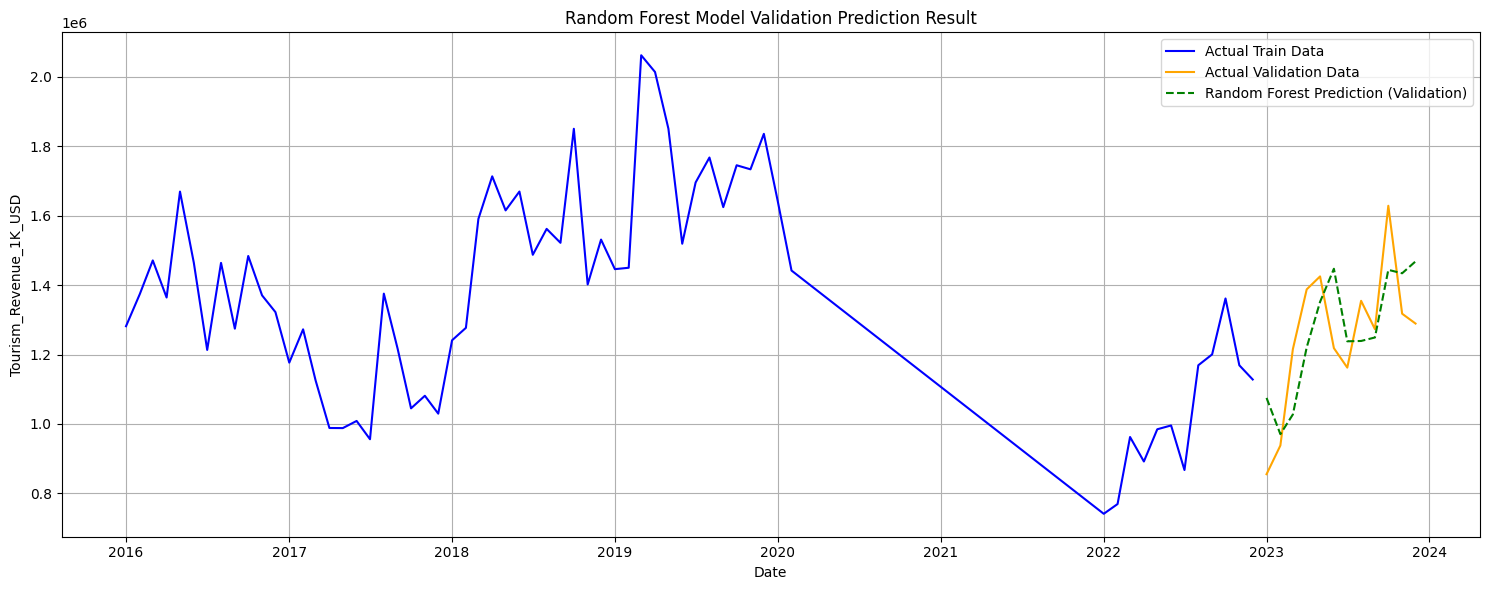

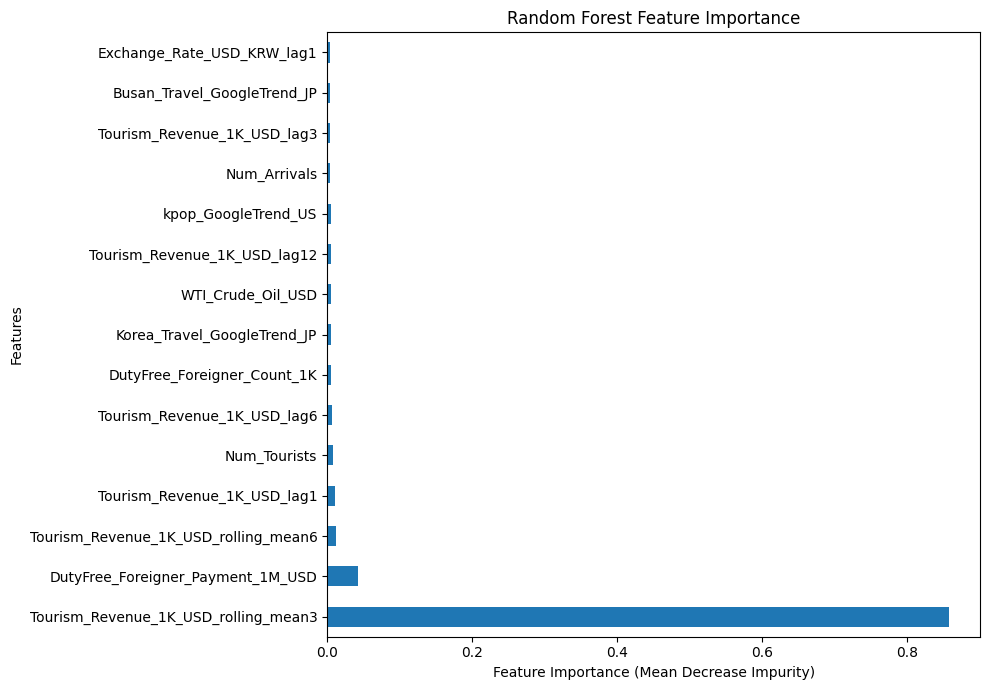


Random Forest Test MAE: 103452.84
Random Forest Test RMSE: 134061.41
Random Forest Test R2: 0.58


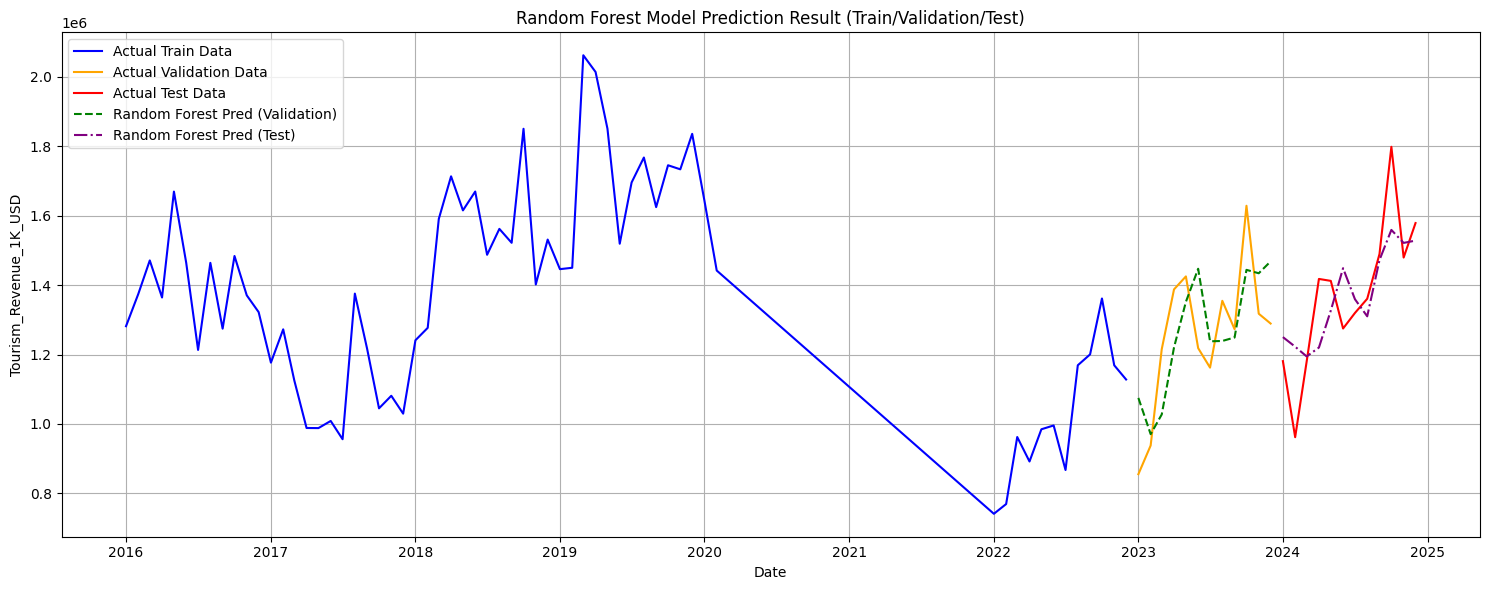

--- Random Forest Model Training and Evaluation Completed ---


In [11]:
print("--- Random Forest Model Training and Evaluation Started ---")

# Random Forest Regressor 모델 학습
rf_model = RandomForestRegressor(
    n_estimators=100,      # 트리의 개수
    max_depth=10,          # 각 트리의 최대 깊이
    min_samples_leaf=5,    # 리프 노드가 되기 위한 최소 샘플 수
    random_state=42,       # 재현성을 위한 시드
    n_jobs=-1              # 모든 코어 사용
)

rf_model.fit(X_train, y_train)

# 검증 세트 예측
rf_val_preds = rf_model.predict(X_val)

# 평가 지표 계산
mae_rf_val = mean_absolute_error(y_val, rf_val_preds)
rmse_rf_val = np.sqrt(mean_squared_error(y_val, rf_val_preds))
r2_rf_val = r2_score(y_val, rf_val_preds)

print(f"\nRandom Forest Validation MAE: {mae_rf_val:.2f}")
print(f"Random Forest Validation RMSE: {rmse_rf_val:.2f}")
print(f"Random Forest Validation R2: {r2_rf_val:.2f}")

# 예측 결과 시각화
plt.figure(figsize=(15, 6))
plt.plot(y_train.index, y_train, label='Actual Train Data', color='blue')
plt.plot(y_val.index, y_val, label='Actual Validation Data', color='orange')
plt.plot(X_val.index, rf_val_preds, label='Random Forest Prediction (Validation)', color='green', linestyle='--')
plt.title('Random Forest Model Validation Prediction Result')
plt.xlabel('Date')
plt.ylabel(target_col) # 번역된 컬럼명 사용
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 특성 중요도 시각화
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importances.nlargest(15).plot(kind='barh', figsize=(10, 7))
plt.title('Random Forest Feature Importance')
plt.xlabel('Feature Importance (Mean Decrease Impurity)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# 테스트 세트 예측 (2024년 데이터가 있는 경우)
if not X_test.empty:
    rf_test_preds = rf_model.predict(X_test)
    mae_rf_test = mean_absolute_error(y_test, rf_test_preds)
    rmse_rf_test = np.sqrt(mean_squared_error(y_test, rf_test_preds))
    r2_rf_test = r2_score(y_test, rf_test_preds)

    print(f"\nRandom Forest Test MAE: {mae_rf_test:.2f}")
    print(f"Random Forest Test RMSE: {rmse_rf_test:.2f}")
    print(f"Random Forest Test R2: {r2_rf_test:.2f}")

    # 테스트 예측 결과 시각화
    plt.figure(figsize=(15, 6))
    plt.plot(y_train.index, y_train, label='Actual Train Data', color='blue')
    plt.plot(y_val.index, y_val, label='Actual Validation Data', color='orange')
    plt.plot(y_test.index, y_test, label='Actual Test Data', color='red')
    plt.plot(X_val.index, rf_val_preds, label='Random Forest Pred (Validation)', color='green', linestyle='--')
    plt.plot(X_test.index, rf_test_preds, label='Random Forest Pred (Test)', color='purple', linestyle='-.')
    plt.title('Random Forest Model Prediction Result (Train/Validation/Test)')
    plt.xlabel('Date')
    plt.ylabel(target_col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("--- Random Forest Model Training and Evaluation Completed ---")

--- XGBoost Model Training and Evaluation Started ---

XGBoost Validation MAE: 107538.34
XGBoost Validation RMSE: 123871.76
XGBoost Validation R2: 0.61


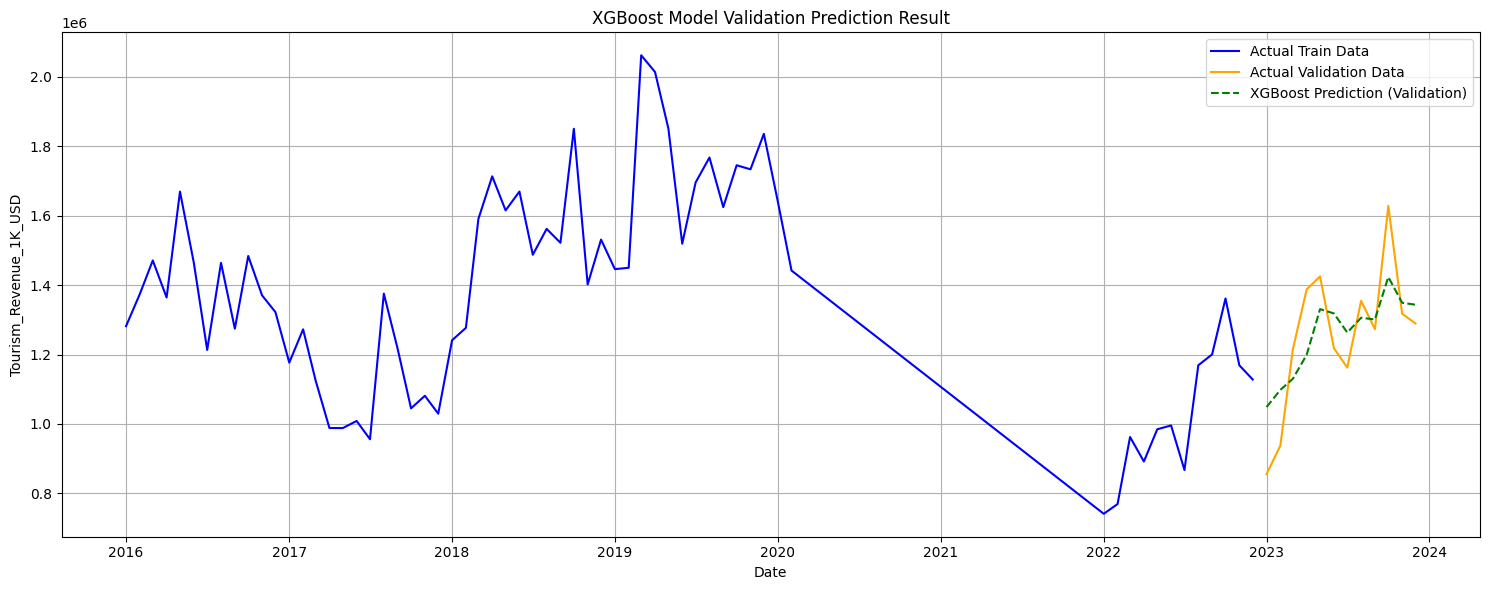

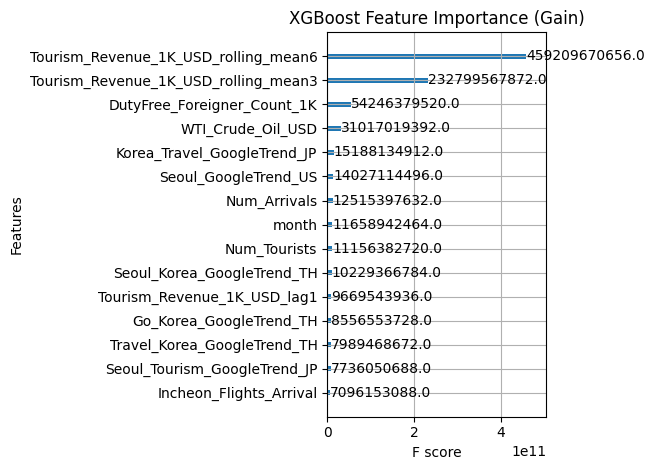


XGBoost Test MAE: 122229.65
XGBoost Test RMSE: 160153.75
XGBoost Test R2: 0.39


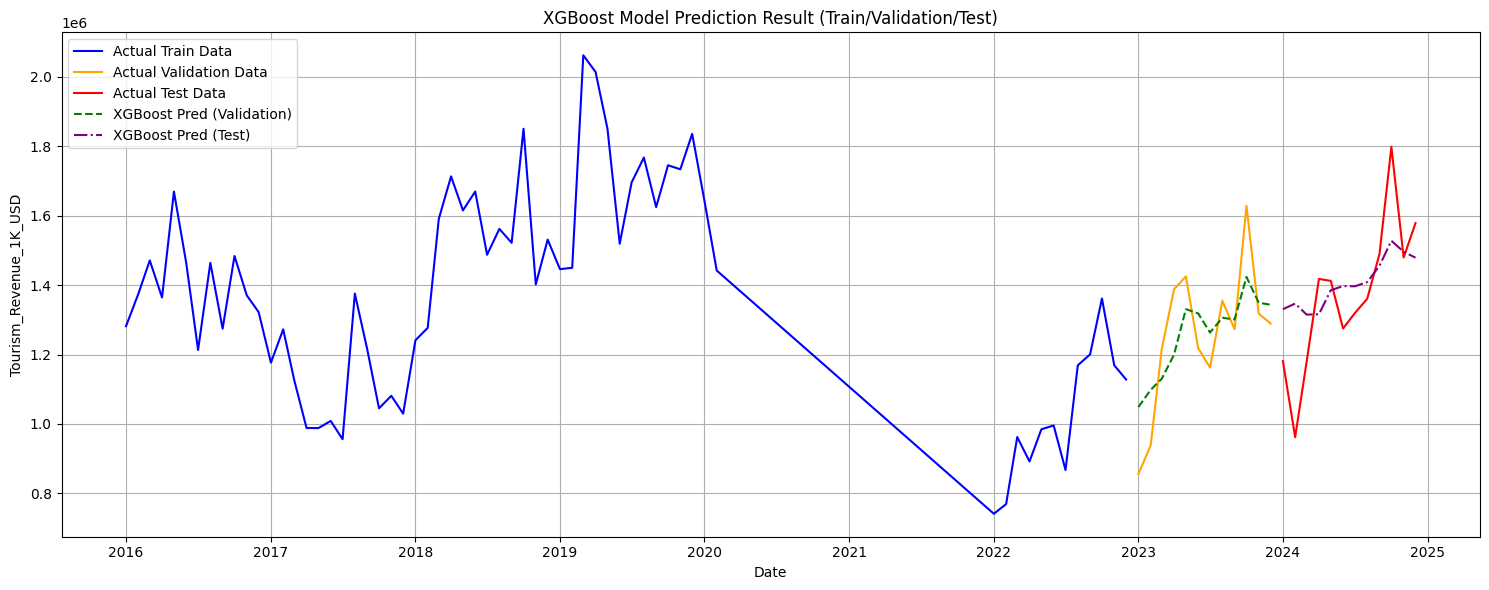

--- XGBoost Model Training and Evaluation Completed ---


In [12]:
print("--- XGBoost Model Training and Evaluation Started ---")

# LightGBM에서 컬럼명 문제 발생 시 다시 실행할 수 있도록 함수 재정의
import re
def clean_col_names(df_input): # 함수 인자명 변경
    df_temp = df_input.copy() # 원본 데이터프레임에 영향 없도록 복사
    cols = df_temp.columns
    new_cols = []
    for col in cols:
        new_col = col.replace(' ', '_')
        new_col = re.sub(r'[^\w_]', '', new_col) # 한글도 제거하도록 수정 (LightGBM 호환성)
        new_cols.append(new_col)
    df_temp.columns = new_cols
    return df_temp

# XGBoost는 한글 컬럼명에 문제가 없지만, LightGBM과의 일관성을 위해 적용
X_train_xgb = clean_col_names(X_train)
X_val_xgb = clean_col_names(X_val)
X_test_xgb = clean_col_names(X_test)


# XGBoost Regressor 모델 학습
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,
    eval_metric='rmse'
)

xgb_model.fit(X_train_xgb, y_train,
              eval_set=[(X_val_xgb, y_val)],
              verbose=False)

# 검증 세트 예측
xgb_val_preds = xgb_model.predict(X_val_xgb)

# 평가 지표 계산
mae_xgb_val = mean_absolute_error(y_val, xgb_val_preds)
rmse_xgb_val = np.sqrt(mean_squared_error(y_val, xgb_val_preds))
r2_xgb_val = r2_score(y_val, xgb_val_preds)

print(f"\nXGBoost Validation MAE: {mae_xgb_val:.2f}")
print(f"XGBoost Validation RMSE: {rmse_xgb_val:.2f}")
print(f"XGBoost Validation R2: {r2_xgb_val:.2f}")

# 예측 결과 시각화
plt.figure(figsize=(15, 6))
plt.plot(y_train.index, y_train, label='Actual Train Data', color='blue')
plt.plot(y_val.index, y_val, label='Actual Validation Data', color='orange')
plt.plot(X_val.index, xgb_val_preds, label='XGBoost Prediction (Validation)', color='green', linestyle='--')
plt.title('XGBoost Model Validation Prediction Result')
plt.xlabel('Date')
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 특성 중요도 시각화
xgb.plot_importance(xgb_model, importance_type='gain', max_num_features=15, title='XGBoost Feature Importance (Gain)')
plt.tight_layout()
plt.show()

# 테스트 세트 예측 (2024년 데이터가 있는 경우)
if not X_test.empty:
    xgb_test_preds = xgb_model.predict(X_test_xgb)
    mae_xgb_test = mean_absolute_error(y_test, xgb_test_preds)
    rmse_xgb_test = np.sqrt(mean_squared_error(y_test, xgb_test_preds))
    r2_xgb_test = r2_score(y_test, xgb_test_preds)

    print(f"\nXGBoost Test MAE: {mae_xgb_test:.2f}")
    print(f"XGBoost Test RMSE: {rmse_xgb_test:.2f}")
    print(f"XGBoost Test R2: {r2_xgb_test:.2f}")

    # 테스트 예측 결과 시각화
    plt.figure(figsize=(15, 6))
    plt.plot(y_train.index, y_train, label='Actual Train Data', color='blue')
    plt.plot(y_val.index, y_val, label='Actual Validation Data', color='orange')
    plt.plot(y_test.index, y_test, label='Actual Test Data', color='red')
    plt.plot(X_val.index, xgb_val_preds, label='XGBoost Pred (Validation)', color='green', linestyle='--')
    plt.plot(X_test.index, xgb_test_preds, label='XGBoost Pred (Test)', color='purple', linestyle='-.')
    plt.title('XGBoost Model Prediction Result (Train/Validation/Test)')
    plt.xlabel('Date')
    plt.ylabel(target_col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("--- XGBoost Model Training and Evaluation Completed ---")

--- LightGBM Model Training and Evaluation Started ---
Cleaned X_train columns for LightGBM:
['Num_Tourists', 'Avg_Spend_Per_Tourist_USD', 'Num_Arrivals', '서울_평균_기온', '부산_평균_기온', '제주_평균_기온', '서울경기_평균_강수일수', '부산경남_평균_강수일수', '제주_평균_강수일수', '공휴일', 'Incheon_Flights_Arrival', 'Korea_GoogleTrend_US', 'Seoul_GoogleTrend_US', 'Seoul_Travel_GoogleTrend_US', 'Korea_Travel_GoogleTrend_US', 'kpop_GoogleTrend_US', 'Korea_Travel_GoogleTrend_JP', 'Seoul_Tourism_GoogleTrend_JP', 'Busan_Travel_GoogleTrend_JP', 'Travel_Korea_GoogleTrend_TH', 'Seoul_Korea_GoogleTrend_TH', 'Go_Korea_GoogleTrend_TH', 'Exchange_Rate_USD_KRW', 'Transportation_Subway_Annual', 'DutyFree_Foreigner_Payment_1M_USD', 'DutyFree_Foreigner_Count_1K', 'WTI_Crude_Oil_USD', 'Pandemic', 'Korea_CPI', 'year', 'month', 'quarter', 'day_of_week', 'day_of_year', 'week_of_year', 'Tourism_Revenue_1K_USD_lag1', 'Tourism_Revenue_1K_USD_lag3', 'Tourism_Revenue_1K_USD_lag6', 'Tourism_Revenue_1K_USD_lag12', 'Num_Tourists_lag1', 'Exchange_Rate_USD_KRW_

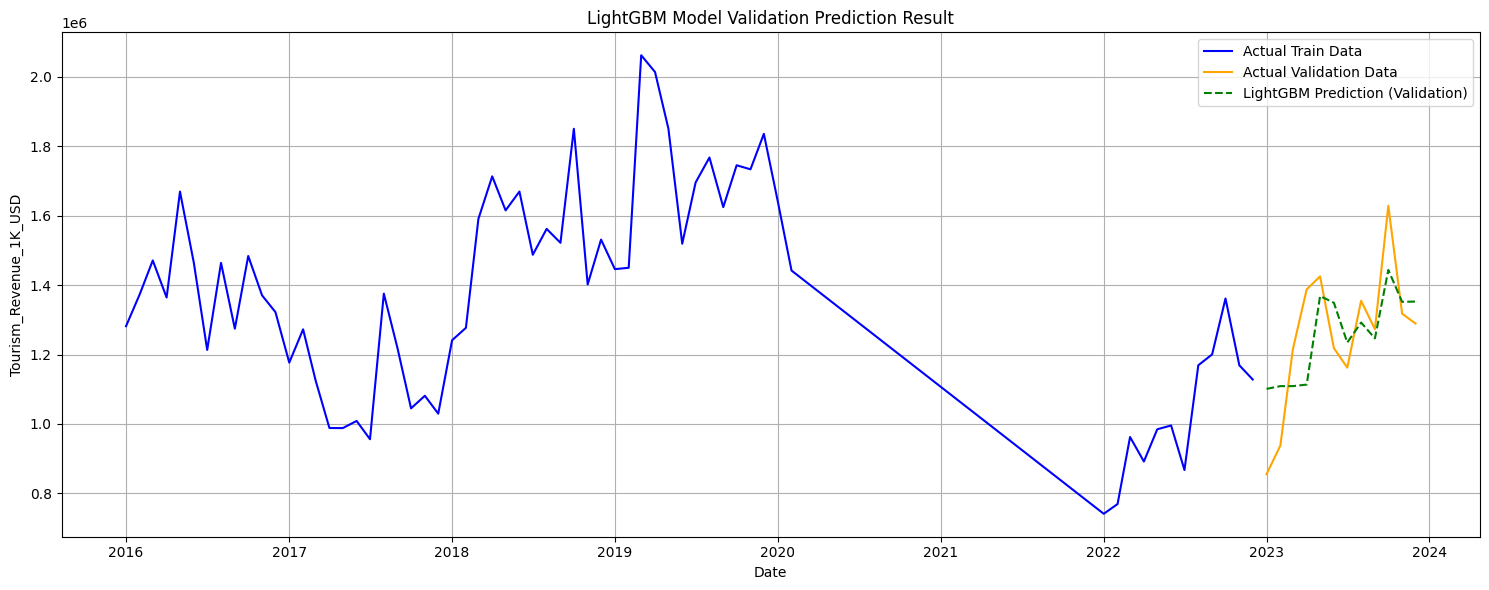

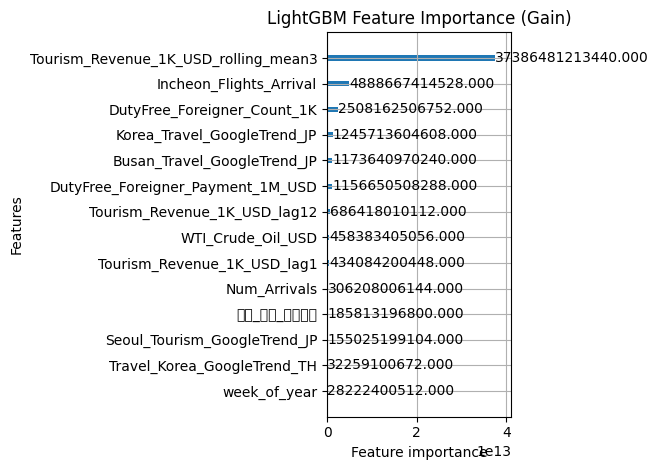


LightGBM Test MAE: 126581.72
LightGBM Test RMSE: 150551.22
LightGBM Test R2: 0.46


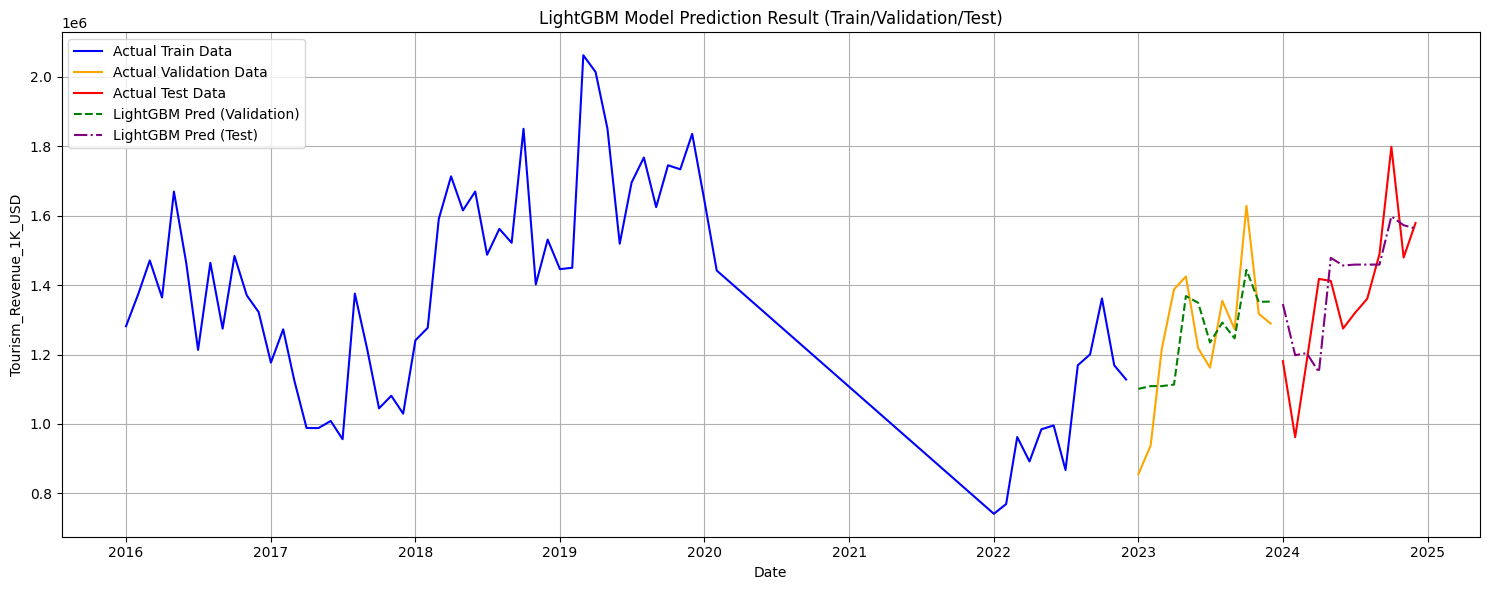

--- LightGBM Model Training and Evaluation Completed ---


In [13]:
print("--- LightGBM Model Training and Evaluation Started ---")

# LightGBM은 컬럼명에 특정 특수문자가 있거나 한글이 있으면 오류가 발생할 수 있습니다.
# 따라서 LightGBM 모델 학습 전에 컬럼명을 정제하는 것이 좋습니다.
# 이 함수는 이전 셀에서 정의했지만, 독립적인 셀 실행을 위해 다시 포함합니다.
import re
def clean_col_names(df_input):
    df_temp = df_input.copy()
    cols = df_temp.columns
    new_cols = []
    for col in cols:
        new_col = col.replace(' ', '_')
        new_col = re.sub(r'[^\w_]', '', new_col) # 한글도 제거하도록 수정 (LightGBM 호환성)
        new_cols.append(new_col)
    df_temp.columns = new_cols
    return df_temp

# LightGBM을 위한 컬럼명 정제
X_train_lgb = clean_col_names(X_train)
X_val_lgb = clean_col_names(X_val)
X_test_lgb = clean_col_names(X_test) # 테스트 세트도 미리 정리

print("Cleaned X_train columns for LightGBM:")
print(X_train_lgb.columns.tolist())
print("-" * 50)

# LightGBM Regressor 모델 학습
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1
)

lgb_model.fit(X_train_lgb, y_train,
              eval_set=[(X_val_lgb, y_val)],
              eval_metric='mae',
              callbacks=[lgb.early_stopping(50, verbose=False)])

# 검증 세트 예측
lgb_val_preds = lgb_model.predict(X_val_lgb)

# 평가 지표 계산
mae_lgb_val = mean_absolute_error(y_val, lgb_val_preds)
rmse_lgb_val = np.sqrt(mean_squared_error(y_val, lgb_val_preds))
r2_lgb_val = r2_score(y_val, lgb_val_preds)

print(f"\nLightGBM Validation MAE: {mae_lgb_val:.2f}")
print(f"LightGBM Validation RMSE: {rmse_lgb_val:.2f}")
print(f"LightGBM Validation R2: {r2_lgb_val:.2f}")

# 예측 결과 시각화
plt.figure(figsize=(15, 6))
plt.plot(y_train.index, y_train, label='Actual Train Data', color='blue')
plt.plot(y_val.index, y_val, label='Actual Validation Data', color='orange')
plt.plot(X_val.index, lgb_val_preds, label='LightGBM Prediction (Validation)', color='green', linestyle='--')
plt.title('LightGBM Model Validation Prediction Result')
plt.xlabel('Date')
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 특성 중요도 시각화
lgb.plot_importance(lgb_model, importance_type='gain', max_num_features=15, title='LightGBM Feature Importance (Gain)')
plt.tight_layout()
plt.show()

# 테스트 세트 예측 (2024년 데이터가 있는 경우)
if not X_test.empty:
    lgb_test_preds = lgb_model.predict(X_test_lgb)
    mae_lgb_test = mean_absolute_error(y_test, lgb_test_preds)
    rmse_lgb_test = np.sqrt(mean_squared_error(y_test, lgb_test_preds))
    r2_lgb_test = r2_score(y_test, lgb_test_preds)

    print(f"\nLightGBM Test MAE: {mae_lgb_test:.2f}")
    print(f"LightGBM Test RMSE: {rmse_lgb_test:.2f}")
    print(f"LightGBM Test R2: {r2_lgb_test:.2f}")

    # 테스트 예측 결과 시각화
    plt.figure(figsize=(15, 6))
    plt.plot(y_train.index, y_train, label='Actual Train Data', color='blue')
    plt.plot(y_val.index, y_val, label='Actual Validation Data', color='orange')
    plt.plot(y_test.index, y_test, label='Actual Test Data', color='red')
    plt.plot(X_val.index, lgb_val_preds, label='LightGBM Pred (Validation)', color='green', linestyle='--')
    plt.plot(X_test.index, lgb_test_preds, label='LightGBM Pred (Test)', color='purple', linestyle='-.')
    plt.title('LightGBM Model Prediction Result (Train/Validation/Test)')
    plt.xlabel('Date')
    plt.ylabel(target_col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("--- LightGBM Model Training and Evaluation Completed ---")